## Graph Neural Network Property Predictor


## Imports

In [1]:
# Main Imports
import torch
import random
import numpy as np
import pandas as pd

# Profiling
import cProfile
import pstats
from pstats import SortKey

# Import Local Files
from model import GNN
from utils.config import FEATURE_NAMES, RESIDUAL_G_FEATURES, TRAINING_CONFIG
import utils.data_utils as DataUtils
import utils.visualization as Visualization
from utils.feature_analysis import permutation_feature_importance
from utils.visualization import plot_feature_importance

## Execution

In [2]:
# Profile the main training routine
# profiler = cProfile.Profile()
# profiler.enable()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# For reference
"""
GRAPH_METRICS = [
    "Density",
    "AvgClustering",
    "AvgPathLength",
    "DegreeAssortativity",
    "Transitivity",
    "ConnectedComponents",
    "MaxDegree",
    "MinDegree",
    "AvgDegree",
    "GlobalEfficiency"
]
"""

# Select target feature for analysis
target_feature = "GMinus_" + "DegreeAssortativity"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

# Generate different graphs for training and test to test generalization
print("Generating graphs...")
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=TRAINING_CONFIG["graph_size"], edge_prob=0.2)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=TRAINING_CONFIG["graph_size"], edge_prob=0.2)

print(f"Train graph: {len(G_train)} nodes, {G_train.number_of_edges()} edges")
print(f"Test graph: {len(G_test)} nodes, {G_test.number_of_edges()} edges")

print("\nProcessing graph data...")
train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

# Initialize Model
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
print(f"FEATURE_NAMES length: {len(FEATURE_NAMES)}")

# # Make sure the dimensions match
# if node_feature_dim != len(FEATURE_NAMES):
#     print(f"Warning: Feature dimension mismatch! Expected {len(FEATURE_NAMES)}, got {node_feature_dim}")

def is_discrete_metric(metric_name):
    """Check if a metric is discrete (integer-valued) and needs special handling"""
    return metric_name in ["ConnectedComponents", "MaxDegree", "MinDegree"]
problem_type = 'integer' if is_discrete_metric(target_feature) else 'continuous'

model = GNN(node_feature_dim=len(FEATURE_NAMES), is_continuous=problem_type == 'continuous')
# print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")


# Train model
print("\nTraining model...")
losses, trained_model, feature_stats = model.train_model_with_features(
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate elapsed time and profiling results
# profiler.disable()
# print("\nProfiling Results:")
# stats = pstats.Stats(profiler).sort_stats(SortKey.TIME)
# stats.print_stats(20)  # Show top 20 time-consuming functions



Generating graphs...
Train graph: 100 nodes, 976 edges
Test graph: 100 nodes, 1034 edges

Processing graph data...

Initializing model...
Node feature dimension: 11
FEATURE_NAMES length: 11

Training model...

Applied initial scaling factor: -0.0798


Training Progress:
Epoch 0: Train Loss = 7.9480e-03, Test Loss = 1.0137e-01
Epoch 10: Train Loss = 2.5569e-02, Test Loss = 1.1560e-02
Epoch 20: Train Loss = 5.4982e-03, Test Loss = 1.2128e-04
Epoch 30: Train Loss = 4.8129e-04, Test Loss = 5.4195e-03
Epoch 40: Train Loss = 1.1622e-03, Test Loss = 5.2288e-03
Epoch 50: Train Loss = 4.6838e-03, Test Loss = 4.5685e-03
Epoch 60: Train Loss = 7.3404e-03, Test Loss = 3.5184e-03
Epoch 70: Train Loss = 2.6468e-04, Test Loss = 2.3694e-02
Epoch 80: Train Loss = 1.8537e-03, Test Loss = 1.0434e-02
Epoch 90: Train Loss = 5.4851e-04, Test Loss = 3.4825e-04
Epoch 100: Train Loss = 3.5938e-05, Test Loss = 8.4526e-04
Epoch 110: Train Loss = 3.5440e-04, Test Loss = 2.8358e-03
Epoch 120: Train Loss = 1.0397e-

## Visualization

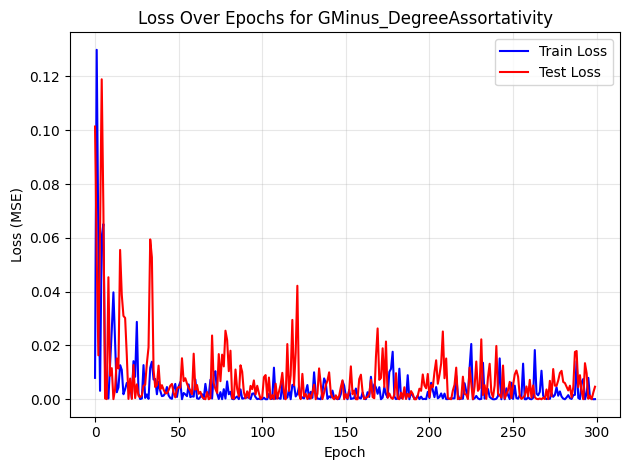


Model Predictions Analysis:
Using 300 sampled target values from training
Average prediction: -0.022952
Average actual value: -0.023380
Std dev of actual values: 0.018896
Average absolute error: 0.014626
Standard deviation of predictions: 0.022808


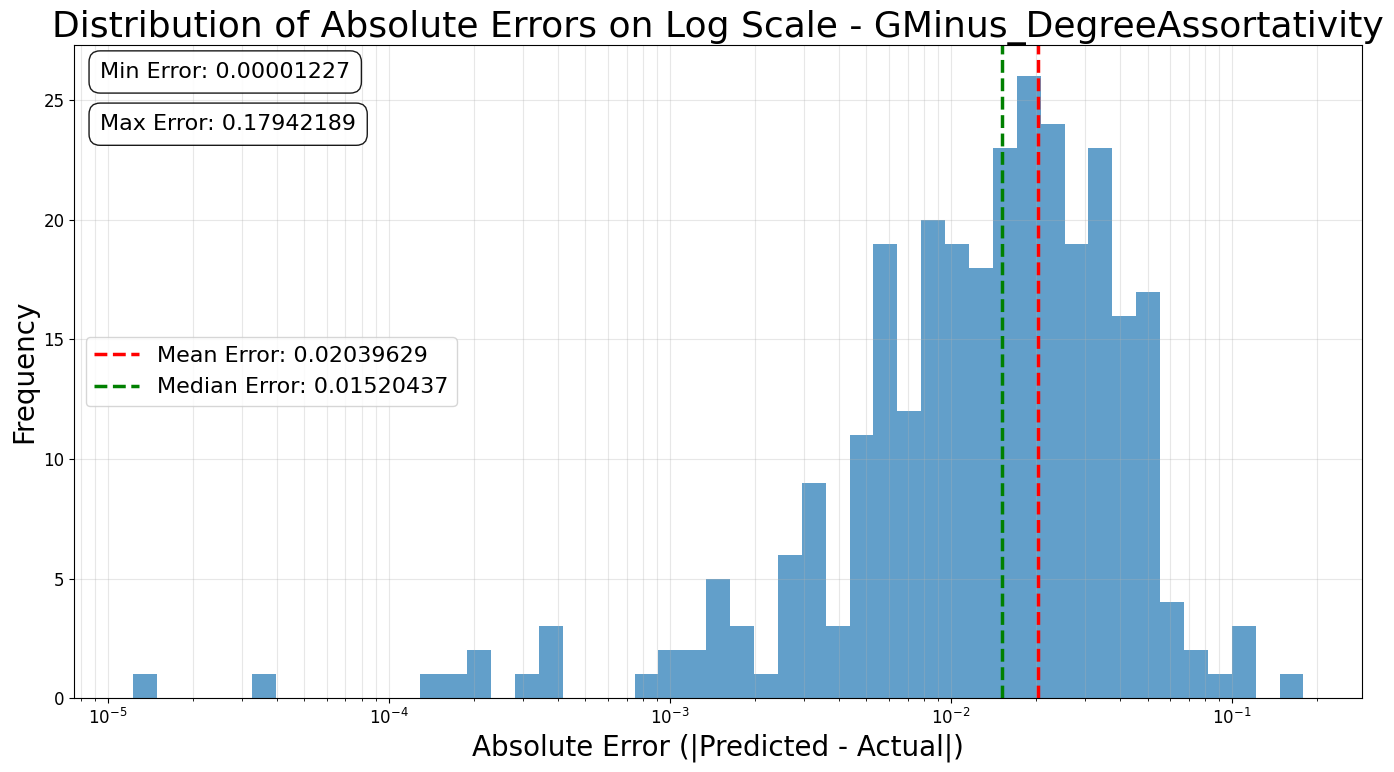

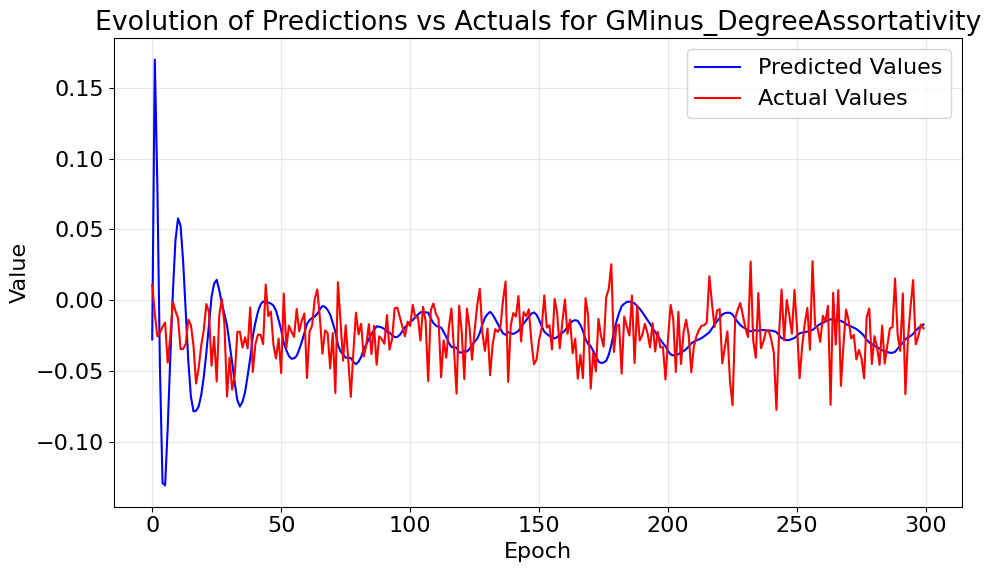


=== Node Feature Statistics ===
                 Feature     Mean      Min      Max  Std Dev  Variance  All Identical
      Node_Metric_Degree 0.650667 0.300000 1.000000 0.135686  0.018411          False
  Node_Metric_Clustering 0.200884 0.106061 0.305556 0.036151  0.001307          False
 Node_Metric_NeighborDeg 0.679499 0.609524 0.766667 0.029766  0.000886          False
 Node_Metric_Betweenness 0.086683 0.000442 0.345173 0.077755  0.006046          False
   Node_Metric_Closeness 5.502207 4.950000 5.892857 0.168482  0.028386          False
    Node_Metric_PageRank 0.100000 0.055831 0.144271 0.017067  0.000291          False
  Node_Metric_CoreNumber 0.993846 0.692308 1.000000 0.035551  0.001264          False
    Node_Metric_LocalEff 0.320216 0.263636 0.383333 0.020513  0.000421          False
 Node_Metric_Eigenvector 0.977521 0.453679 1.510626 0.210840  0.044453          False
Node_Metric_LocalDensity 0.281743 0.214286 0.444444 0.036168  0.001308          False
  Node_Metric_IsSelec

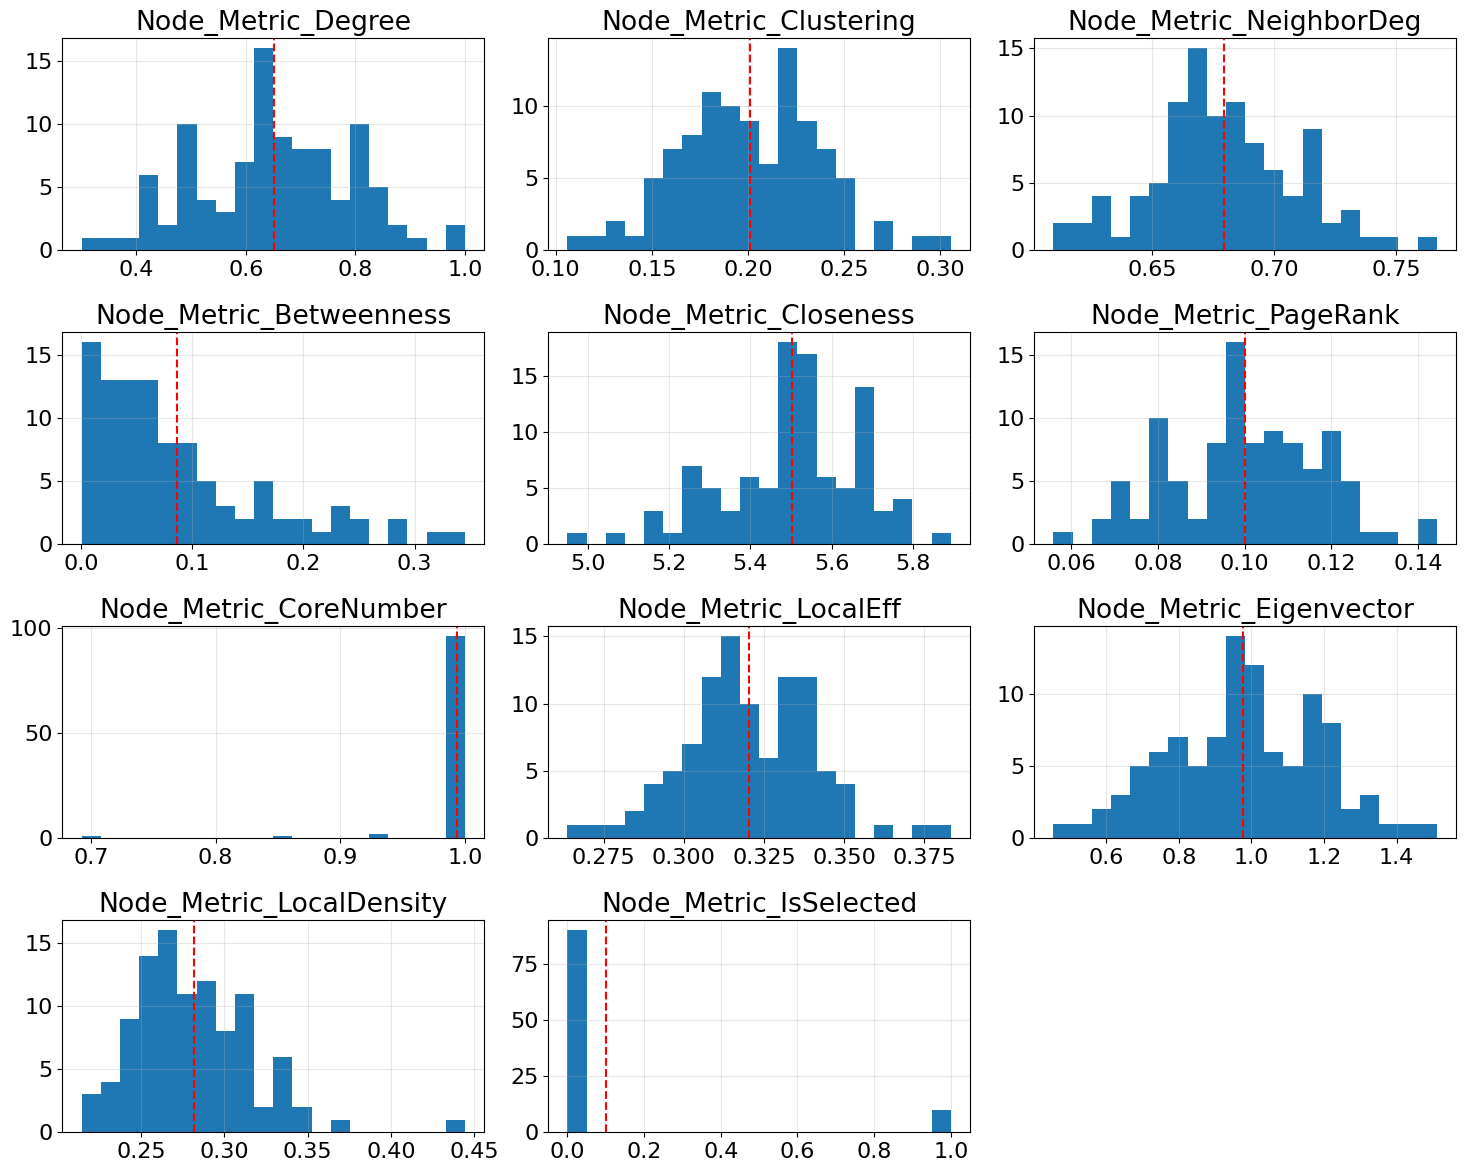

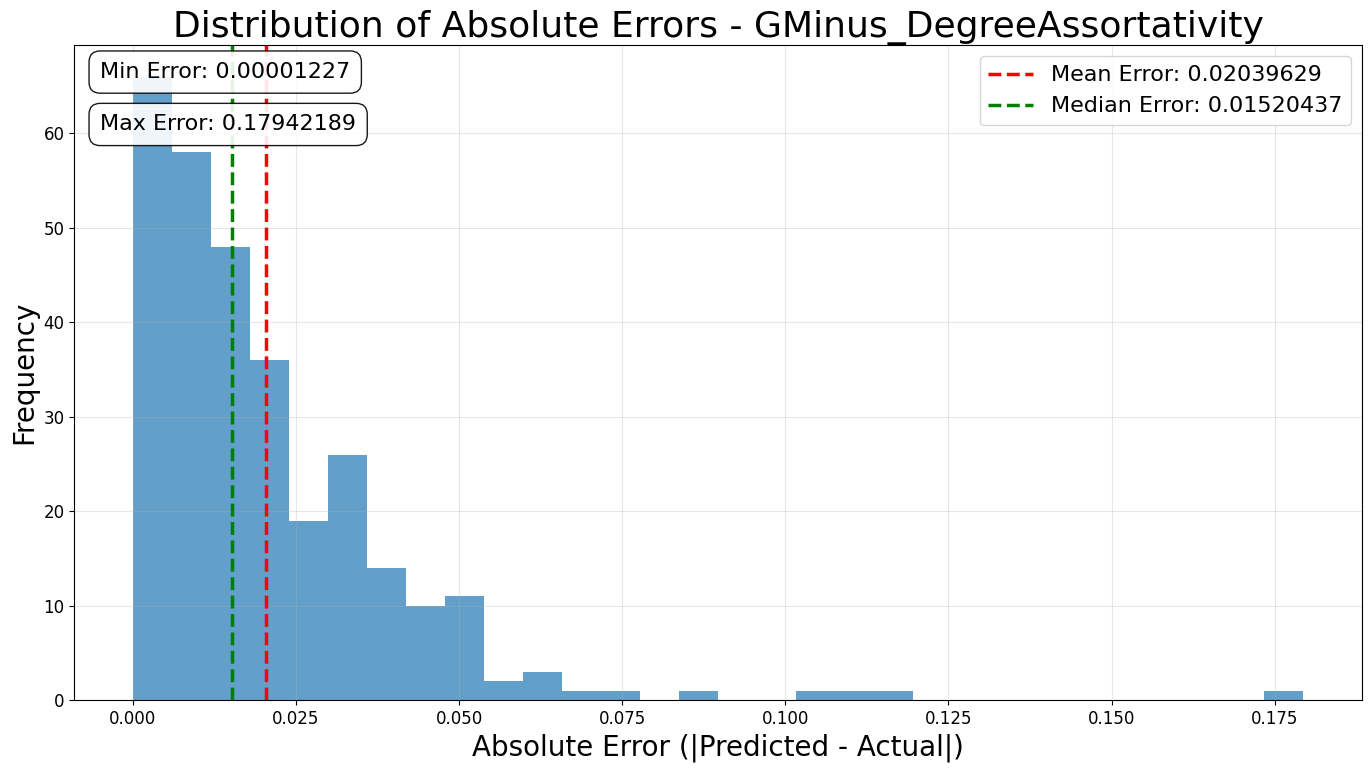

In [3]:
# Do visualization
Visualization.visualize_results(losses, trained_model, test_data, target_feature, feature_stats)
feature_stats_df = Visualization.visualize_feature_statistics(train_data, show_histograms=True)
Visualization.plot_error_distribution(
    feature_stats.predicted_values.cpu().numpy(), 
    feature_stats.actual_values.cpu().numpy(), 
    target_feature, 
    log_scale=False
)
# Visualization.visualize_feature_pairs(train_data, num_pairs=15, prioritize_variance=True, use_node_features=True)
# pca, components = Visualization.visualize_pca(train_data, n_components=3, use_node_features=True)

## Feature Importance Analysis


Initializing model...
Node feature dimension: 11

Training model...

Applied initial scaling factor: -0.0944


Training Progress:
Epoch 0: Train Loss = 3.5450e-03, Test Loss = 9.9821e-02
Epoch 10: Train Loss = 1.8813e-02, Test Loss = 1.1173e-03
Epoch 20: Train Loss = 1.5560e-02, Test Loss = 1.4112e-03
Epoch 30: Train Loss = 1.0525e-02, Test Loss = 9.3321e-03
Epoch 40: Train Loss = 8.0290e-05, Test Loss = 1.3868e-02
Epoch 50: Train Loss = 2.7634e-03, Test Loss = 1.6298e-02
Epoch 60: Train Loss = 1.2114e-02, Test Loss = 9.1766e-03
Epoch 70: Train Loss = 4.8003e-05, Test Loss = 7.7831e-03
Epoch 80: Train Loss = 3.5795e-08, Test Loss = 7.5295e-03
Epoch 90: Train Loss = 2.5847e-05, Test Loss = 1.9319e-03
Epoch 100: Train Loss = 4.6454e-05, Test Loss = 1.2623e-03
Epoch 110: Train Loss = 8.6297e-04, Test Loss = 5.5644e-03
Epoch 120: Train Loss = 4.1920e-03, Test Loss = 1.3519e-04
Epoch 130: Train Loss = 2.5902e-02, Test Loss = 4.0511e-03
Epoch 140: Train Loss = 8.2499e-05, Test Loss = 9.1088

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Calculating permutation feature importance...
Baseline test_loss: 0.000132


Features: 100%|██████████| 11/11 [00:00<00:00, 343.74it/s]

  Node_Metric_Degree: 0.000000 ± 0.000000
  Node_Metric_Clustering: 0.000000 ± 0.000000
  Node_Metric_NeighborDeg: 0.000000 ± 0.000000
  Node_Metric_Betweenness: -0.000001 ± 0.000000
  Node_Metric_Closeness: -0.000001 ± 0.000001
  Node_Metric_PageRank: 0.000000 ± 0.000000
  Node_Metric_CoreNumber: -0.000000 ± 0.000000
  Node_Metric_LocalEff: 0.000000 ± 0.000000
  Node_Metric_Eigenvector: -0.000001 ± 0.000001
  Node_Metric_LocalDensity: 0.000000 ± 0.000000
Updated sheet 'DegreeAssortativity' in existing file: results/feature_importances.xlsx


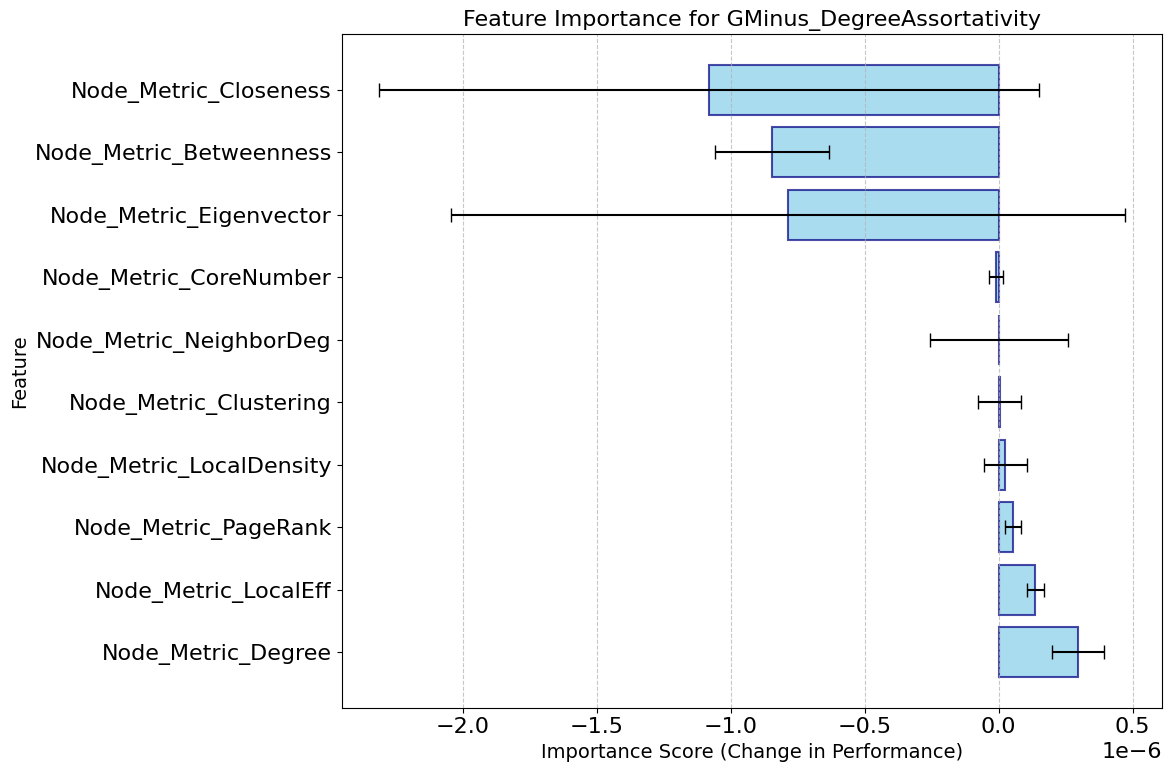


Feature Importance Ranking:
                    Feature    Importance           Std
0        Node_Metric_Degree  2.958501e-07  9.558646e-08
1      Node_Metric_LocalEff  1.373167e-07  3.051749e-08
2      Node_Metric_PageRank  5.261002e-08  2.995107e-08
3  Node_Metric_LocalDensity  2.494198e-08  8.016653e-08
4    Node_Metric_Clustering  3.138363e-09  7.853417e-08
5   Node_Metric_NeighborDeg  6.305830e-10  2.562928e-07
6    Node_Metric_CoreNumber -9.521803e-09  2.707740e-08
7   Node_Metric_Eigenvector -7.860411e-07  1.256289e-06
8   Node_Metric_Betweenness -8.449036e-07  2.127383e-07
9     Node_Metric_Closeness -1.081906e-06  1.230564e-06


In [4]:
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
model = GNN(node_feature_dim=len(FEATURE_NAMES))

def is_discrete_metric(metric_name):
    """Check if a metric is discrete (integer-valued) and needs special handling"""
    return metric_name in ["ConnectedComponents", "MaxDegree", "MinDegree"]
problem_type = 'integer' if is_discrete_metric(target_feature) else 'continuous'

print("\nTraining model...")
losses, trained_model, feature_stats = model.train_model_with_features(
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate permutation feature importance
importance_df = permutation_feature_importance(
    trained_model, 
    test_data, 
    FEATURE_NAMES, 
    n_repeats=3,
    metric='test_loss',
    higher_is_better=False,
    target_feature=target_feature,
    save_to_excel=True
)

# Plot feature importance
plot_feature_importance(importance_df, title=f"Feature Importance for {target_feature}")

# Print importance ranking
print("\nFeature Importance Ranking:")
pd.set_option('display.max_rows', None)
print(importance_df)

In [5]:
# Feature importance analysis across all graph metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
from IPython.display import display
from torch_geometric.data import Data

# Create results dataframe to store all metrics
results_df = pd.DataFrame()

# Function to train model and get top features
def analyze_label(target_metric, train_with_top_n=3):
    print(f"\n{'='*80}")
    print(f"ANALYZING: {target_metric}")
    print(f"{'='*80}")
    
    # Set up target feature and verify it's valid
    target_feature = "GMinus_" + target_metric
    if target_feature not in RESIDUAL_G_FEATURES:
        print(f"Skipping invalid feature: {target_feature}")
        return None
        
    target_idx = RESIDUAL_G_FEATURES.index(target_feature)
    
    # Generate graphs (can reuse the same graphs for all metrics to save time)
    print("Generating graphs...")
    G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=TRAINING_CONFIG["graph_size"], edge_prob=0.2)
    G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=TRAINING_CONFIG["graph_size"], edge_prob=0.2)
    
    print("\nProcessing graph data...")
    train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
    test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

    def is_discrete_metric(metric_name):
        """Check if a metric is discrete (integer-valued) and needs special handling"""
        return metric_name in ["ConnectedComponents", "MaxDegree", "MinDegree"]
    problem_type = 'integer' if is_discrete_metric(target_metric) else 'continuous'
    
    # 1. Train on all features
    print("\nTraining model with ALL features...")
    model = GNN(node_feature_dim=len(FEATURE_NAMES), is_continuous=problem_type == 'continuous')
    losses, trained_model, feature_stats = model.train_model_with_features(
        train_data=train_data,
        test_data=test_data, 
        target_idx=target_idx
    )
    
    # Get full model R2 score
    with torch.no_grad():
        output = trained_model(test_data)
        target = test_data.y.reshape(-1, 1).to(output.device)
        loss = trained_model.criterion(output, target)
        print(f"Test loss: {loss.item():.8e}")
        full_r2 = DataUtils.normalized_r2_score(target.cpu(), output.cpu())
        print(f"Calculated R2 score: {full_r2:.4f}")
    
    # 2. Calculate feature importances
    importance_df = permutation_feature_importance(
        trained_model, 
        test_data, 
        FEATURE_NAMES, 
        n_repeats=3,
        metric='test_loss',
        higher_is_better=False,
        target_feature=target_feature,
        save_to_excel=False
    )
    
    # Calculate percentage of total importance (using absolute values)
    total_importance = importance_df['Importance'].abs().sum()
    importance_df['Importance_Pct'] = (importance_df['Importance'].abs() / total_importance) * 100
    
    # 3. Get top N features - use raw importance values
    top_features = importance_df.nlargest(train_with_top_n, 'Importance')['Feature'].tolist()
    print(f"\nTop {train_with_top_n} features: {', '.join(top_features)}")
    
    # Print importance percentages for debugging
    print("\nFeature importance percentages:")
    for feature in top_features:
        pct = importance_df.loc[importance_df['Feature'] == feature, 'Importance_Pct'].values[0]
        print(f"{feature}: {pct:.2f}%")
    
    # 4. Train model with only top features
    print(f"\nTraining model with TOP {train_with_top_n} features only...")

    # Create feature mask for top features
    feature_mask = [False] * len(FEATURE_NAMES)
    for feature in top_features:
        feature_idx = FEATURE_NAMES.index(feature)
        feature_mask[feature_idx] = True

    # Process graph data with only the selected features
    train_data_top = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx, feature_mask=feature_mask)
    test_data_top = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx, feature_mask=feature_mask)

    # ADD THESE TWO LINES to attach feature mask to data objects
    train_data_top.feature_mask = feature_mask
    test_data_top.feature_mask = feature_mask

    # Verify dimensions
    filtered_feature_dim = train_data_top.x.shape[1]
    print(f"Filtered feature dimension: {filtered_feature_dim}")

    # Create model with the correct number of input features
    model_top = GNN(node_feature_dim=filtered_feature_dim, is_continuous=problem_type == 'continuous')
    
    # Train model with top features
    losses_top, trained_model_top, _ = model_top.train_model_with_features(
        train_data=train_data_top,
        test_data=test_data_top,
        target_idx=target_idx
    )
    
    # Get top model R2 score
    with torch.no_grad():
        output_top = trained_model_top(test_data_top)
        target_top = test_data_top.y.reshape(-1, 1).to(output_top.device)
        loss_top = trained_model_top.criterion(target_top, output_top)
        print(f"Top features test loss: {loss_top.item():.8e}")
        top_r2 = DataUtils.normalized_r2_score(target_top.cpu(), output_top.cpu())
        print(f"Top features R2 score: {top_r2:.4f}")
    
    # Create a row for this target
    row_data = {
        'Target': target_metric,
        'R2_Full': full_r2,
        'R2_Top3': top_r2,
    }
    
    # Add importance percentages for each feature
    for feature in FEATURE_NAMES:
        pct_values = importance_df.loc[importance_df['Feature'] == feature, 'Importance_Pct'].values
        row_data[feature] = pct_values[0] if len(pct_values) > 0 else 0.0
    
    return row_data

# Run analysis for all graph metrics
graph_metrics = [
    "Density",
    "AvgClustering",
    "AvgPathLength",
    "DegreeAssortativity",
    "Transitivity",
    "ConnectedComponents",
    "MaxDegree",
    "MinDegree",
    "AvgDegree",
    "GlobalEfficiency"
]

all_results = []
for metric in graph_metrics:
    row_data = analyze_label(metric)
    if row_data:
        all_results.append(row_data)

# Create results dataframe
results_df = pd.DataFrame(all_results)

feature_cols = [f for f in FEATURE_NAMES if f != "Node_Metric_IsSelected"]
col_order = ['Target', 'R2_Full', 'R2_Top3'] + feature_cols
results_df = results_df[col_order]

# Create a styled version for display
def style_dataframe(df):
    # Create a styler object
    styler = df.style
    
    # Create a complete format dictionary for all columns at once
    format_dict = {
        'R2_Full': '{:.4f}',
        'R2_Top3': '{:.4f}'
    }
    
    # Add percentage formatting for all feature columns
    for feature in feature_cols:
        format_dict[feature] = '{:.2f}%'
    
    # Apply formatting to all columns in one operation
    styler.format(format_dict)
    
    # Color code R2 scores (higher is better)
    styler.background_gradient(cmap='RdYlGn', subset=['R2_Full', 'R2_Top3'], vmin=0, vmax=1)
    
    # Color code feature importances (higher is more important)
    feature_min = 0  # Percentages are always >= 0
    feature_max = df[feature_cols].max().max()
    
    # Use a blue gradient for feature importance
    styler.background_gradient(
        cmap='Blues', 
        subset=feature_cols,
        vmin=feature_min,
        vmax=feature_max
    )
    
    return styler

# Display the styled dataframe
styled_results = style_dataframe(results_df)
display(styled_results)

# Save the raw results to Excel for further analysis
results_df.to_excel("results/feature_importance_comparison.xlsx", index=False)


ANALYZING: Density
Generating graphs...

Processing graph data...

Training model with ALL features...

Applied initial scaling factor: -0.2057


Training Progress:
Epoch 0: Train Loss = 1.7143e-06, Test Loss = 1.1059e-03
Epoch 10: Train Loss = 2.5230e-04, Test Loss = 3.4317e-04
Epoch 20: Train Loss = 4.9219e-07, Test Loss = 2.0094e-04
Epoch 30: Train Loss = 5.5187e-05, Test Loss = 6.5179e-08
Epoch 40: Train Loss = 1.2202e-05, Test Loss = 1.7069e-05
Epoch 50: Train Loss = 4.5399e-05, Test Loss = 2.3795e-06
Epoch 60: Train Loss = 1.7032e-05, Test Loss = 5.1887e-05
Epoch 70: Train Loss = 3.9730e-06, Test Loss = 2.3441e-05
Epoch 80: Train Loss = 1.2659e-05, Test Loss = 1.7131e-04
Epoch 90: Train Loss = 4.1533e-05, Test Loss = 1.3784e-04
Epoch 100: Train Loss = 1.5763e-05, Test Loss = 1.4613e-04
Epoch 110: Train Loss = 6.7171e-06, Test Loss = 1.8042e-04
Epoch 120: Train Loss = 4.6104e-06, Test Loss = 1.1801e-04
Epoch 130: Train Loss = 2.5926e-05, Test Loss = 4.6874e-05
Epoch 140: Train Lo

Features: 100%|██████████| 11/11 [00:00<00:00, 366.62it/s]

  Node_Metric_Degree: 0.000010 ± 0.000004
  Node_Metric_Clustering: -0.000000 ± 0.000000
  Node_Metric_NeighborDeg: 0.000000 ± 0.000000
  Node_Metric_Betweenness: 0.000000 ± 0.000000
  Node_Metric_Closeness: 0.000011 ± 0.000001
  Node_Metric_PageRank: -0.000001 ± 0.000001
  Node_Metric_CoreNumber: 0.000002 ± 0.000004
  Node_Metric_LocalEff: 0.000000 ± 0.000000
  Node_Metric_Eigenvector: -0.000005 ± 0.000015
  Node_Metric_LocalDensity: -0.000001 ± 0.000000

Top 3 features: Node_Metric_Closeness, Node_Metric_Degree, Node_Metric_CoreNumber

Feature importance percentages:
Node_Metric_Closeness: 35.42%
Node_Metric_Degree: 34.16%
Node_Metric_CoreNumber: 7.52%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: 1.1377


Training Progress:
Epoch 0: Train Loss = 3.0550e-06, Test Loss = 1.1596e-03


Epoch 10: Train Loss = 3.9556e-04, Test Loss = 1.0319e-04
Epoch 20: Train Loss = 7.0134e-05, Test Loss = 1.4820e-04
Epoch 30: Train Loss = 2.1477e-05, Test Loss = 6.5602e-05
Epoch 40: Train Loss = 2.8297e-05, Test Loss = 8.8388e-05
Epoch 50: Train Loss = 4.4951e-05, Test Loss = 2.2094e-04
Epoch 60: Train Loss = 2.5123e-08, Test Loss = 1.0605e-05
Epoch 70: Train Loss = 1.3185e-06, Test Loss = 3.5216e-05
Epoch 80: Train Loss = 7.1985e-07, Test Loss = 7.2294e-05
Epoch 90: Train Loss = 1.3721e-05, Test Loss = 5.9827e-06
Epoch 100: Train Loss = 3.0567e-08, Test Loss = 6.6350e-05
Epoch 110: Train Loss = 1.0688e-07, Test Loss = 3.1404e-06
Epoch 120: Train Loss = 4.7482e-05, Test Loss = 3.9043e-06
Epoch 130: Train Loss = 1.9340e-06, Test Loss = 1.6808e-05
Epoch 140: Train Loss = 2.0536e-05, Test Loss = 1.4911e-05
Epoch 150: Train Loss = 5.0175e-06, Test Loss = 1.7369e-06
Epoch 160: Train Loss = 1.6516e-05, Test Loss = 1.1589e-06
Epoch 170: Train Loss = 2.3567e-06, Test Loss = 2.4684e-07
Epoch 

Features: 100%|██████████| 11/11 [00:00<00:00, 342.73it/s]

  Node_Metric_Degree: -0.000003 ± 0.000003
  Node_Metric_Clustering: -0.000001 ± 0.000004
  Node_Metric_NeighborDeg: -0.000001 ± 0.000001
  Node_Metric_Betweenness: 0.000010 ± 0.000002
  Node_Metric_Closeness: -0.000019 ± 0.000004
  Node_Metric_PageRank: 0.000001 ± 0.000000
  Node_Metric_CoreNumber: 0.000003 ± 0.000001
  Node_Metric_LocalEff: 0.000001 ± 0.000002
  Node_Metric_Eigenvector: 0.000016 ± 0.000044
  Node_Metric_LocalDensity: 0.000001 ± 0.000001

Top 3 features: Node_Metric_Eigenvector, Node_Metric_Betweenness, Node_Metric_CoreNumber

Feature importance percentages:
Node_Metric_Eigenvector: 29.71%
Node_Metric_Betweenness: 18.20%
Node_Metric_CoreNumber: 4.61%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -0.7585


Training Progress:
Epoch 0: Train Loss = 5.5203e-06, Test Loss = 1.0846e-04


Epoch 10: Train Loss = 1.5174e-05, Test Loss = 3.6589e-06
Epoch 20: Train Loss = 1.2413e-05, Test Loss = 9.7313e-06
Epoch 30: Train Loss = 2.8498e-05, Test Loss = 5.9701e-06
Epoch 40: Train Loss = 1.0098e-05, Test Loss = 3.7832e-04
Epoch 50: Train Loss = 3.8434e-05, Test Loss = 3.2878e-06
Epoch 60: Train Loss = 1.9620e-08, Test Loss = 1.7307e-05
Epoch 70: Train Loss = 1.4093e-05, Test Loss = 6.2665e-05
Epoch 80: Train Loss = 3.1498e-05, Test Loss = 2.1380e-06
Epoch 90: Train Loss = 1.0431e-05, Test Loss = 3.2864e-05
Epoch 100: Train Loss = 7.6926e-06, Test Loss = 2.2848e-05
Epoch 110: Train Loss = 2.6645e-05, Test Loss = 7.4101e-06
Epoch 120: Train Loss = 1.8368e-06, Test Loss = 7.2320e-05
Epoch 130: Train Loss = 4.7376e-06, Test Loss = 2.2665e-05
Epoch 140: Train Loss = 3.8032e-05, Test Loss = 6.2271e-05
Epoch 150: Train Loss = 3.5058e-07, Test Loss = 2.0145e-08
Epoch 160: Train Loss = 1.0199e-05, Test Loss = 1.4439e-04
Epoch 170: Train Loss = 3.8126e-05, Test Loss = 1.2375e-07
Epoch 

Features: 100%|██████████| 11/11 [00:00<00:00, 366.68it/s]

  Node_Metric_Degree: 0.000410 ± 0.000870
  Node_Metric_Clustering: 0.001802 ± 0.000634
  Node_Metric_NeighborDeg: -0.000236 ± 0.000637
  Node_Metric_Betweenness: -0.002955 ± 0.001863
  Node_Metric_Closeness: -0.000748 ± 0.002537
  Node_Metric_PageRank: 0.000136 ± 0.000106
  Node_Metric_CoreNumber: -0.000131 ± 0.000190
  Node_Metric_LocalEff: -0.000010 ± 0.000055
  Node_Metric_Eigenvector: -0.004790 ± 0.001890
  Node_Metric_LocalDensity: 0.000818 ± 0.000889

Top 3 features: Node_Metric_Clustering, Node_Metric_LocalDensity, Node_Metric_Degree

Feature importance percentages:
Node_Metric_Clustering: 14.97%
Node_Metric_LocalDensity: 6.79%
Node_Metric_Degree: 3.41%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -26.8918


Training Progress:
Epoch 0: Train Loss = 1.2070e-04, Test Loss = 4.6651e-02


Epoch 10: Train Loss = 1.3465e-03, Test Loss = 3.6668e-02
Epoch 20: Train Loss = 1.6594e-05, Test Loss = 2.7454e-02
Epoch 30: Train Loss = 1.7524e-04, Test Loss = 2.5758e-02
Epoch 40: Train Loss = 1.4865e-04, Test Loss = 2.5090e-02
Epoch 50: Train Loss = 3.2256e-04, Test Loss = 2.5882e-02
Epoch 60: Train Loss = 1.0825e-04, Test Loss = 2.4787e-02
Epoch 70: Train Loss = 1.6152e-04, Test Loss = 2.4196e-02
Epoch 80: Train Loss = 6.5003e-04, Test Loss = 2.7205e-02
Epoch 90: Train Loss = 1.4001e-06, Test Loss = 2.6812e-02
Epoch 100: Train Loss = 5.7585e-08, Test Loss = 2.6999e-02
Epoch 110: Train Loss = 1.0146e-03, Test Loss = 2.6622e-02
Epoch 120: Train Loss = 1.7236e-05, Test Loss = 2.2465e-02
Epoch 130: Train Loss = 5.7865e-06, Test Loss = 2.2628e-02
Epoch 140: Train Loss = 5.3809e-04, Test Loss = 2.2863e-02
Epoch 150: Train Loss = 4.3939e-05, Test Loss = 2.4398e-02
Epoch 160: Train Loss = 1.3131e-04, Test Loss = 2.6581e-02
Epoch 170: Train Loss = 2.0754e-05, Test Loss = 2.5489e-02
Epoch 

Features: 100%|██████████| 11/11 [00:00<00:00, 316.67it/s]

  Node_Metric_Degree: -0.000001 ± 0.000008
  Node_Metric_Clustering: -0.000026 ± 0.000018
  Node_Metric_NeighborDeg: -0.000015 ± 0.000010
  Node_Metric_Betweenness: -0.000031 ± 0.000011
  Node_Metric_Closeness: -0.000006 ± 0.000002
  Node_Metric_PageRank: 0.000007 ± 0.000004
  Node_Metric_CoreNumber: 0.000003 ± 0.000016
  Node_Metric_LocalEff: -0.000000 ± 0.000000
  Node_Metric_Eigenvector: -0.000014 ± 0.000015
  Node_Metric_LocalDensity: 0.000000 ± 0.000005

Top 3 features: Node_Metric_PageRank, Node_Metric_CoreNumber, Node_Metric_LocalDensity

Feature importance percentages:
Node_Metric_PageRank: 6.37%
Node_Metric_CoreNumber: 3.01%
Node_Metric_LocalDensity: 0.46%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -0.4223


Training Progress:
Epoch 0: Train Loss = 2.9771e-03, Test Loss = 2.0650e-02


Epoch 10: Train Loss = 1.2853e-03, Test Loss = 6.1413e-03
Epoch 20: Train Loss = 2.9894e-04, Test Loss = 2.3491e-03
Epoch 30: Train Loss = 1.2363e-03, Test Loss = 3.6159e-03
Epoch 40: Train Loss = 2.1208e-03, Test Loss = 3.1581e-03
Epoch 50: Train Loss = 7.5168e-04, Test Loss = 6.8438e-04
Epoch 60: Train Loss = 1.4841e-03, Test Loss = 1.4489e-03
Epoch 70: Train Loss = 1.4021e-04, Test Loss = 3.7179e-03
Epoch 80: Train Loss = 2.3477e-02, Test Loss = 8.8021e-03
Epoch 90: Train Loss = 5.2083e-03, Test Loss = 3.0263e-03
Epoch 100: Train Loss = 1.6340e-04, Test Loss = 1.5653e-03
Epoch 110: Train Loss = 2.8402e-04, Test Loss = 4.5908e-06
Epoch 120: Train Loss = 2.3329e-02, Test Loss = 1.2280e-02
Epoch 130: Train Loss = 1.2044e-03, Test Loss = 3.7304e-03
Epoch 140: Train Loss = 1.0191e-06, Test Loss = 1.2858e-03
Epoch 150: Train Loss = 1.8783e-03, Test Loss = 5.8971e-03
Epoch 160: Train Loss = 1.9850e-04, Test Loss = 1.1843e-03
Epoch 170: Train Loss = 2.3699e-03, Test Loss = 5.3743e-03
Epoch 

Features: 100%|██████████| 11/11 [00:00<00:00, 333.33it/s]

  Node_Metric_Degree: 0.000001 ± 0.000001
  Node_Metric_Clustering: -0.000000 ± 0.000000
  Node_Metric_NeighborDeg: -0.000000 ± 0.000000
  Node_Metric_Betweenness: -0.000000 ± 0.000000
  Node_Metric_Closeness: 0.000001 ± 0.000001
  Node_Metric_PageRank: -0.000000 ± 0.000000
  Node_Metric_CoreNumber: 0.000000 ± 0.000001
  Node_Metric_LocalEff: 0.000000 ± 0.000000
  Node_Metric_Eigenvector: -0.000000 ± 0.000000
  Node_Metric_LocalDensity: -0.000000 ± 0.000000

Top 3 features: Node_Metric_Closeness, Node_Metric_Degree, Node_Metric_CoreNumber

Feature importance percentages:
Node_Metric_Closeness: 34.54%
Node_Metric_Degree: 12.89%
Node_Metric_CoreNumber: 3.86%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: 0.4234


Training Progress:
Epoch 0: Train Loss = 4.9261e-06, Test Loss = 3.9006e-04


Epoch 10: Train Loss = 3.1375e-04, Test Loss = 9.0242e-05
Epoch 20: Train Loss = 2.5354e-04, Test Loss = 6.6878e-05
Epoch 30: Train Loss = 4.0149e-06, Test Loss = 1.5608e-06
Epoch 40: Train Loss = 1.4083e-06, Test Loss = 3.5790e-05
Epoch 50: Train Loss = 1.1545e-05, Test Loss = 4.8115e-06
Epoch 60: Train Loss = 3.1284e-05, Test Loss = 9.1251e-07
Epoch 70: Train Loss = 2.4682e-06, Test Loss = 2.5240e-05
Epoch 80: Train Loss = 1.1188e-05, Test Loss = 1.0933e-04
Epoch 90: Train Loss = 7.1102e-06, Test Loss = 4.1715e-05
Epoch 100: Train Loss = 2.1077e-06, Test Loss = 1.8754e-04
Epoch 110: Train Loss = 3.6764e-05, Test Loss = 3.4247e-06
Epoch 120: Train Loss = 2.8885e-05, Test Loss = 6.5192e-06
Epoch 130: Train Loss = 5.7695e-05, Test Loss = 5.3538e-05
Epoch 140: Train Loss = 2.4899e-05, Test Loss = 1.0217e-06
Epoch 150: Train Loss = 8.0970e-05, Test Loss = 8.5014e-08
Epoch 160: Train Loss = 3.3806e-07, Test Loss = 1.4974e-05
Epoch 170: Train Loss = 6.1267e-06, Test Loss = 7.2875e-05
Epoch 

c:\Users\Will\Documents\School Stuff\IndStudy\molecule-predictor\model.py:196: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  base_loss = F.huber_loss(pred, target, delta=1.0)


Epoch 10: Train Loss = 2.8181e-03, Test Loss = 0.0000e+00
Epoch 20: Train Loss = 1.8553e-03, Test Loss = 0.0000e+00
Epoch 30: Train Loss = 1.0240e-03, Test Loss = 0.0000e+00
Epoch 40: Train Loss = 5.5899e-04, Test Loss = 0.0000e+00
Epoch 50: Train Loss = 9.7818e-04, Test Loss = 0.0000e+00
Epoch 60: Train Loss = 3.9694e-03, Test Loss = 0.0000e+00
Epoch 70: Train Loss = 2.9230e-03, Test Loss = 0.0000e+00
Epoch 80: Train Loss = 1.3195e-03, Test Loss = 0.0000e+00
Epoch 90: Train Loss = 2.6871e-03, Test Loss = 0.0000e+00
Epoch 100: Train Loss = 7.8259e-04, Test Loss = 0.0000e+00
Epoch 110: Train Loss = 1.3517e-03, Test Loss = 0.0000e+00
Epoch 120: Train Loss = 6.5702e-04, Test Loss = 0.0000e+00
Epoch 130: Train Loss = 1.5820e-03, Test Loss = 0.0000e+00
Epoch 140: Train Loss = 2.8535e-03, Test Loss = 0.0000e+00
Epoch 150: Train Loss = 5.0531e-03, Test Loss = 0.0000e+00
Epoch 160: Train Loss = 1.9586e-03, Test Loss = 0.0000e+00
Epoch 170: Train Loss = 7.2540e-04, Test Loss = 0.0000e+00
Epoch 

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 1.11964485e-03
Target mean: 1.00000000e+00, Target variance: 0.00000000e+00
SS_tot: 0.00000000e+00, SS_res: 1.11964485e-03
Target has near-zero variance, using normalized MAE: 3.34610939e-02
Calculated R2 score: 0.9665

Calculating permutation feature importance...
Baseline test_loss: 0.001120


Features: 100%|██████████| 11/11 [00:00<00:00, 326.76it/s]
c:\Users\Will\Documents\School Stuff\IndStudy\molecule-predictor\model.py:196: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  base_loss = F.huber_loss(pred, target, delta=1.0)


  Node_Metric_Degree: 0.000049 ± 0.000034
  Node_Metric_Clustering: -0.000015 ± 0.000051
  Node_Metric_NeighborDeg: -0.000004 ± 0.000008
  Node_Metric_Betweenness: 0.000012 ± 0.000053
  Node_Metric_Closeness: 0.000051 ± 0.000027
  Node_Metric_PageRank: 0.000001 ± 0.000015
  Node_Metric_CoreNumber: -0.000001 ± 0.000082
  Node_Metric_LocalEff: 0.000107 ± 0.000042
  Node_Metric_Eigenvector: 0.000290 ± 0.000062
  Node_Metric_LocalDensity: 0.000096 ± 0.000044

Top 3 features: Node_Metric_Eigenvector, Node_Metric_LocalEff, Node_Metric_LocalDensity

Feature importance percentages:
Node_Metric_Eigenvector: 46.32%
Node_Metric_LocalEff: 17.09%
Node_Metric_LocalDensity: 15.27%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -3.6258


Training Progress:
Epoch 0: Train Loss = 3.2008e-04, Test Loss = 0.0000e+00
Epoch 10: Train Loss = 2.2966e-03, Test Loss = 0.0000e+00
Epoch 20: Train Loss = 4.9827e-04, Test Loss = 0.0000e+00
Epoch 30: Train 

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Top features test loss: 1.82969344e-03
Target mean: 1.00000000e+00, Target variance: 0.00000000e+00
SS_tot: 0.00000000e+00, SS_res: 1.82969344e-03
Target has near-zero variance, using normalized MAE: 4.27749157e-02
Top features R2 score: 0.9572

ANALYZING: MaxDegree
Generating graphs...

Processing graph data...

Training model with ALL features...

Applied initial scaling factor: -77.0326


Training Progress:
Epoch 0: Train Loss = 5.5642e+00, Test Loss = 5.0000e-01
Epoch 10: Train Loss = 1.0545e+00, Test Loss = 2.5000e+00
Epoch 20: Train Loss = 1.4619e+00, Test Loss = 5.0000e-01
Epoch 30: Train Loss = 2.2340e+00, Test Loss = 3.1936e+00
Epoch 40: Train Loss = 4.8031e-01, Test Loss = 3.4882e+00
Epoch 50: Train Loss = 8.5291e-01, Test Loss = 0.0000e+00
Epoch 60: Train Loss = 9.0931e-03, Test Loss = 2.3022e+00
Epoch 70: Train Loss = 4.5800e-02, Test Loss = 1.8943e-01
Epoch 80: Train Loss = 8.9737e-01, Test Loss = 2.5000e+00
Epoch 90: Train Loss = 1.3443e+00, Test Loss = 2.5000e+00
Epoch 1

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 1.59354286e+01
Target mean: 2.80000000e+01, Target variance: 0.00000000e+00
SS_tot: 0.00000000e+00, SS_res: 1.59354286e+01
Target has near-zero variance, using normalized MAE: 1.42568588e-01
Calculated R2 score: 0.8574

Calculating permutation feature importance...
Baseline test_loss: 15.935429


Features: 100%|██████████| 11/11 [00:00<00:00, 306.16it/s]
c:\Users\Will\Documents\School Stuff\IndStudy\molecule-predictor\model.py:196: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  base_loss = F.huber_loss(pred, target, delta=1.0)


  Node_Metric_Degree: 0.492269 ± 0.294173
  Node_Metric_Clustering: -0.001245 ± 0.014107
  Node_Metric_NeighborDeg: -0.033743 ± 0.229590
  Node_Metric_Betweenness: -0.281641 ± 0.097989
  Node_Metric_Closeness: -0.152728 ± 0.057066
  Node_Metric_PageRank: -0.489224 ± 0.179886
  Node_Metric_CoreNumber: -0.194628 ± 0.170937
  Node_Metric_LocalEff: -0.017803 ± 0.085568
  Node_Metric_Eigenvector: -0.591605 ± 0.227338
  Node_Metric_LocalDensity: 0.166837 ± 0.079714

Top 3 features: Node_Metric_Degree, Node_Metric_LocalDensity, Node_Metric_Clustering

Feature importance percentages:
Node_Metric_Degree: 20.33%
Node_Metric_LocalDensity: 6.89%
Node_Metric_Clustering: 0.05%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: 735.7086


Training Progress:
Epoch 0: Train Loss = 2.5819e-01, Test Loss = 2.2259e+00
Epoch 10: Train Loss = 3.0118e-01, Test Loss = 6.5000e+00
Epoch 20: Train Loss = 2.0998e+00, Test Loss = 2.5000e+00
Epoch 30: Train Lo

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Top features test loss: 3.58246155e+01
Target mean: 2.80000000e+01, Target variance: 0.00000000e+00
SS_tot: 0.00000000e+00, SS_res: 3.58246155e+01
Target has near-zero variance, using normalized MAE: 2.13763103e-01
Top features R2 score: 0.7862

ANALYZING: MinDegree
Generating graphs...

Processing graph data...

Training model with ALL features...

Applied initial scaling factor: 54.0433


Training Progress:
Epoch 0: Train Loss = 1.0865e-01, Test Loss = 2.5000e+00
Epoch 10: Train Loss = 3.1397e-01, Test Loss = 3.4156e+00
Epoch 20: Train Loss = 7.3849e-01, Test Loss = 5.0000e-01
Epoch 30: Train Loss = 5.0381e-01, Test Loss = 2.2132e+00
Epoch 40: Train Loss = 2.1508e-02, Test Loss = 3.8240e-01
Epoch 50: Train Loss = 1.0741e+00, Test Loss = 2.3785e+00
Epoch 60: Train Loss = 6.0308e-01, Test Loss = 1.5000e+00
Epoch 70: Train Loss = 1.5681e-01, Test Loss = 4.2393e+00
Epoch 80: Train Loss = 5.7854e-01, Test Loss = 2.5000e+00
Epoch 90: Train Loss = 9.4333e-01, Test Loss = 4.3840e+00
Epoch 10

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss: 1.12085648e+01
Target mean: 1.10000000e+01, Target variance: 0.00000000e+00
SS_tot: 0.00000000e+00, SS_res: 1.12085648e+01
Target has near-zero variance, using normalized MAE: 3.04356307e-01
Calculated R2 score: 0.6956

Calculating permutation feature importance...
Baseline test_loss: 11.208565


Features: 100%|██████████| 11/11 [00:00<00:00, 309.56it/s]

  Node_Metric_Degree: 0.187710 ± 0.569049
  Node_Metric_Clustering: 0.013402 ± 0.010279
  Node_Metric_NeighborDeg: -0.101854 ± 0.150921
  Node_Metric_Betweenness: 0.322327 ± 0.451358
  Node_Metric_Closeness: 0.140048 ± 0.577661
  Node_Metric_PageRank: 0.071489 ± 0.086412
  Node_Metric_CoreNumber: 0.230843 ± 0.059776
  Node_Metric_LocalEff: -0.001095 ± 0.006874
  Node_Metric_Eigenvector: -0.618177 ± 0.382906
  Node_Metric_LocalDensity: -0.007905 ± 0.011428

Top 3 features: Node_Metric_Betweenness, Node_Metric_CoreNumber, Node_Metric_Degree

Feature importance percentages:
Node_Metric_Betweenness: 19.02%
Node_Metric_CoreNumber: 13.62%
Node_Metric_Degree: 11.08%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -546.3393


Training Progress:
Epoch 0: Train Loss = 9.5562e-01, Test Loss = 1.5000e+00



c:\Users\Will\Documents\School Stuff\IndStudy\molecule-predictor\model.py:196: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  base_loss = F.huber_loss(pred, target, delta=1.0)


Epoch 10: Train Loss = 3.8941e-01, Test Loss = 5.0507e+00
Epoch 20: Train Loss = 2.1073e+00, Test Loss = 5.5000e+00
Epoch 30: Train Loss = 1.6628e-01, Test Loss = 3.5000e+00
Epoch 40: Train Loss = 8.3803e-02, Test Loss = 3.5000e+00
Epoch 50: Train Loss = 7.7114e-01, Test Loss = 3.2484e+00
Epoch 60: Train Loss = 3.6844e-02, Test Loss = 2.5000e+00
Epoch 70: Train Loss = 5.6998e-01, Test Loss = 1.5000e+00
Epoch 80: Train Loss = 1.2838e+00, Test Loss = 4.3335e+00
Epoch 90: Train Loss = 1.0809e+00, Test Loss = 3.5000e+00
Epoch 100: Train Loss = 1.4883e-01, Test Loss = 4.2351e+00
Epoch 110: Train Loss = 6.0929e-01, Test Loss = 1.5000e+00
Epoch 120: Train Loss = 6.2189e-01, Test Loss = 2.5000e+00
Epoch 130: Train Loss = 2.0993e+00, Test Loss = 2.5000e+00
Epoch 140: Train Loss = 1.9954e+00, Test Loss = 4.8323e-01
Epoch 150: Train Loss = 1.7599e-01, Test Loss = 2.5000e+00
Epoch 160: Train Loss = 1.0960e-01, Test Loss = 5.0549e+00
Epoch 170: Train Loss = 1.2457e+00, Test Loss = 1.5000e+00
Epoch 

c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Training model with ALL features...

Applied initial scaling factor: 66.8088


Training Progress:
Epoch 0: Train Loss = 4.0073e-01, Test Loss = 2.3528e-01
Epoch 10: Train Loss = 5.5852e-02, Test Loss = 5.5200e-03
Epoch 20: Train Loss = 1.4436e-02, Test Loss = 4.1020e-03
Epoch 30: Train Loss = 2.9999e-03, Test Loss = 1.5307e-03
Epoch 40: Train Loss = 4.8786e-05, Test Loss = 3.4043e-02
Epoch 50: Train Loss = 1.5220e-01, Test Loss = 6.3189e-02
Epoch 60: Train Loss = 6.5763e-04, Test Loss = 1.1709e-05
Epoch 70: Train Loss = 1.1606e-02, Test Loss = 4.7685e-01
Epoch 80: Train Loss = 3.7098e-01, Test Loss = 2.0611e-02
Epoch 90: Train Loss = 9.2863e-01, Test Loss = 1.8934e-01
Epoch 100: Train Loss = 1.7905e-03, Test Loss = 5.0819e-02
Epoch 110: Train Loss = 1.0763e-03, Test Loss = 8.5956e-03
Epoch 120: Train Loss = 1.9071e-01, Test Loss = 3.8573e-02
Epoch 130: Train Loss = 5.3503e-02, Test Loss = 5.5093e-04
Epoch 140: Train Loss = 4.7513e-03, Test Loss = 7.0108e-03
Epoch 150: Train Loss = 1.2

Features: 100%|██████████| 11/11 [00:00<00:00, 348.12it/s]

  Node_Metric_Degree: -0.019434 ± 0.003498
  Node_Metric_Clustering: -0.004104 ± 0.000454
  Node_Metric_NeighborDeg: -0.000029 ± 0.000196
  Node_Metric_Betweenness: 0.002966 ± 0.006210
  Node_Metric_Closeness: -0.007086 ± 0.008073
  Node_Metric_PageRank: -0.009390 ± 0.001205
  Node_Metric_CoreNumber: -0.005974 ± 0.004072
  Node_Metric_LocalEff: -0.000357 ± 0.000573
  Node_Metric_Eigenvector: -0.008480 ± 0.005412
  Node_Metric_LocalDensity: -0.001091 ± 0.001703

Top 3 features: Node_Metric_Betweenness, Node_Metric_NeighborDeg, Node_Metric_LocalEff

Feature importance percentages:
Node_Metric_Betweenness: 5.04%
Node_Metric_NeighborDeg: 0.05%
Node_Metric_LocalEff: 0.61%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -329.3757


Training Progress:
Epoch 0: Train Loss = 8.2657e-03, Test Loss = 4.3013e+00


Epoch 10: Train Loss = 1.8567e+00, Test Loss = 1.8203e+00
Epoch 20: Train Loss = 6.6157e-03, Test Loss = 6.0412e-01
Epoch 30: Train Loss = 3.4627e-01, Test Loss = 7.4092e-04
Epoch 40: Train Loss = 1.8814e-02, Test Loss = 5.5414e-01
Epoch 50: Train Loss = 1.8494e-03, Test Loss = 5.2085e-02
Epoch 60: Train Loss = 1.2318e-02, Test Loss = 2.3654e-01
Epoch 70: Train Loss = 1.1468e-01, Test Loss = 8.7008e-01
Epoch 80: Train Loss = 5.5348e-02, Test Loss = 1.5932e-01
Epoch 90: Train Loss = 1.3792e-01, Test Loss = 5.7458e-01
Epoch 100: Train Loss = 4.5194e-03, Test Loss = 7.4643e-02
Epoch 110: Train Loss = 1.6343e-02, Test Loss = 5.8878e-01
Epoch 120: Train Loss = 1.5131e-02, Test Loss = 1.7402e+00
Epoch 130: Train Loss = 3.9292e-02, Test Loss = 7.3312e-01
Epoch 140: Train Loss = 2.5171e-02, Test Loss = 6.2634e-01
Epoch 150: Train Loss = 5.6503e-02, Test Loss = 4.7110e-01
Epoch 160: Train Loss = 4.2127e-01, Test Loss = 1.2757e-01
Epoch 170: Train Loss = 7.4358e-03, Test Loss = 9.0322e-01
Epoch 

Features: 100%|██████████| 11/11 [00:00<00:00, 332.10it/s]

  Node_Metric_Degree: -0.001282 ± 0.000049
  Node_Metric_Clustering: 0.000884 ± 0.000403
  Node_Metric_NeighborDeg: -0.000317 ± 0.000165
  Node_Metric_Betweenness: 0.001314 ± 0.000676
  Node_Metric_Closeness: 0.000113 ± 0.000977
  Node_Metric_PageRank: -0.000103 ± 0.000018
  Node_Metric_CoreNumber: -0.000149 ± 0.000524
  Node_Metric_LocalEff: -0.000665 ± 0.000221
  Node_Metric_Eigenvector: 0.000028 ± 0.002115
  Node_Metric_LocalDensity: 0.001736 ± 0.000752

Top 3 features: Node_Metric_LocalDensity, Node_Metric_Betweenness, Node_Metric_Clustering

Feature importance percentages:
Node_Metric_LocalDensity: 26.34%
Node_Metric_Betweenness: 19.93%
Node_Metric_Clustering: 13.42%

Training model with TOP 3 features only...
Filtered feature dimension: 3

Applied initial scaling factor: -27.9672


Training Progress:
Epoch 0: Train Loss = 4.3020e-03, Test Loss = 1.7445e-03


Epoch 10: Train Loss = 8.1662e-05, Test Loss = 3.5703e-06
Epoch 20: Train Loss = 2.4785e-04, Test Loss = 3.6966e-04
Epoch 30: Train Loss = 5.4737e-06, Test Loss = 9.9807e-04
Epoch 40: Train Loss = 5.2704e-05, Test Loss = 2.1157e-04
Epoch 50: Train Loss = 2.3715e-03, Test Loss = 3.2417e-03
Epoch 60: Train Loss = 4.8942e-06, Test Loss = 2.0665e-04
Epoch 70: Train Loss = 5.5204e-04, Test Loss = 1.0400e-03
Epoch 80: Train Loss = 1.6444e-06, Test Loss = 3.3374e-04
Epoch 90: Train Loss = 1.8630e-03, Test Loss = 1.7020e-04
Epoch 100: Train Loss = 1.0532e-03, Test Loss = 4.4690e-06
Epoch 110: Train Loss = 2.9037e-04, Test Loss = 3.2807e-03
Epoch 120: Train Loss = 2.9082e-04, Test Loss = 5.5887e-04
Epoch 130: Train Loss = 5.8251e-04, Test Loss = 3.5725e-04
Epoch 140: Train Loss = 1.7808e-04, Test Loss = 4.3748e-04
Epoch 150: Train Loss = 8.0723e-06, Test Loss = 1.9017e-03
Epoch 160: Train Loss = 6.5700e-04, Test Loss = 2.7123e-04
Epoch 170: Train Loss = 1.1105e-03, Test Loss = 1.8476e-05
Epoch 

,Target,R2_Full,R2_Top3,Node_Metric_Degree,Node_Metric_Clustering,Node_Metric_NeighborDeg,Node_Metric_Betweenness,Node_Metric_Closeness,Node_Metric_PageRank,Node_Metric_CoreNumber,Node_Metric_LocalEff,Node_Metric_Eigenvector,Node_Metric_LocalDensity
0,Density,0.9749,0.9853,34.16%,0.11%,0.31%,0.21%,35.42%,2.15%,7.52%,0.25%,17.55%,2.32%
1,AvgClustering,0.9449,0.9914,4.83%,2.63%,0.90%,18.20%,33.58%,2.57%,4.61%,1.19%,29.71%,1.79%
2,AvgPathLength,0.9452,0.9189,3.41%,14.97%,1.96%,24.55%,6.22%,1.13%,1.09%,0.08%,39.80%,6.79%
3,DegreeAssortativity,0.0000,0.0000,1.26%,25.10%,14.55%,29.51%,5.62%,6.37%,3.01%,0.23%,13.90%,0.46%
4,Transitivity,0.9880,0.9437,12.89%,2.70%,6.64%,9.11%,34.54%,9.15%,3.86%,1.42%,11.26%,8.43%
5,ConnectedComponents,0.9665,0.9572,7.85%,2.32%,0.67%,1.85%,8.16%,0.24%,0.23%,17.09%,46.32%,15.27%
6,MaxDegree,0.8574,0.7862,20.33%,0.05%,1.39%,11.63%,6.31%,20.20%,8.04%,0.74%,24.43%,6.89%
7,MinDegree,0.6956,0.6435,11.08%,0.79%,6.01%,19.02%,8.26%,4.22%,13.62%,0.06%,36.47%,0.47%
8,AvgDegree,0.9905,0.9717,32.99%,6.97%,0.05%,5.04%,12.03%,15.94%,10.14%,0.61%,14.39%,1.85%
9,GlobalEfficiency,0.8597,0.9828,19.45%,13.42%,4.80%,19.93%,1.71%,1.56%,2.25%,10.10%,0.43%,26.34%
